In [267]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df_old = pd.read_csv("WFH-785.csv")

# Basic info and first few rows
print(df_old.info())
print(df_old.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785 entries, 0 to 784
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Gender     785 non-null    int64
 1   Age        785 non-null    int64
 2   Education  785 non-null    int64
 3   WorkExper  785 non-null    int64
 4   Position   785 non-null    int64
 5   WorkField  785 non-null    int64
 6   WFHDay     785 non-null    int64
 7   WFHMems    785 non-null    int64
 8   NoMems     785 non-null    int64
 9   NoKids     785 non-null    int64
 10  WFHP       785 non-null    int64
 11  FWC        785 non-null    int64
 12  SE         785 non-null    int64
 13  WE         785 non-null    int64
dtypes: int64(14)
memory usage: 86.0 KB
None
   Gender  Age  Education  WorkExper  Position  WorkField  WFHDay  WFHMems  \
0       2    4          5          3         3          4       2        1   
1       2    4          4          4         2          2       2        1   
2       

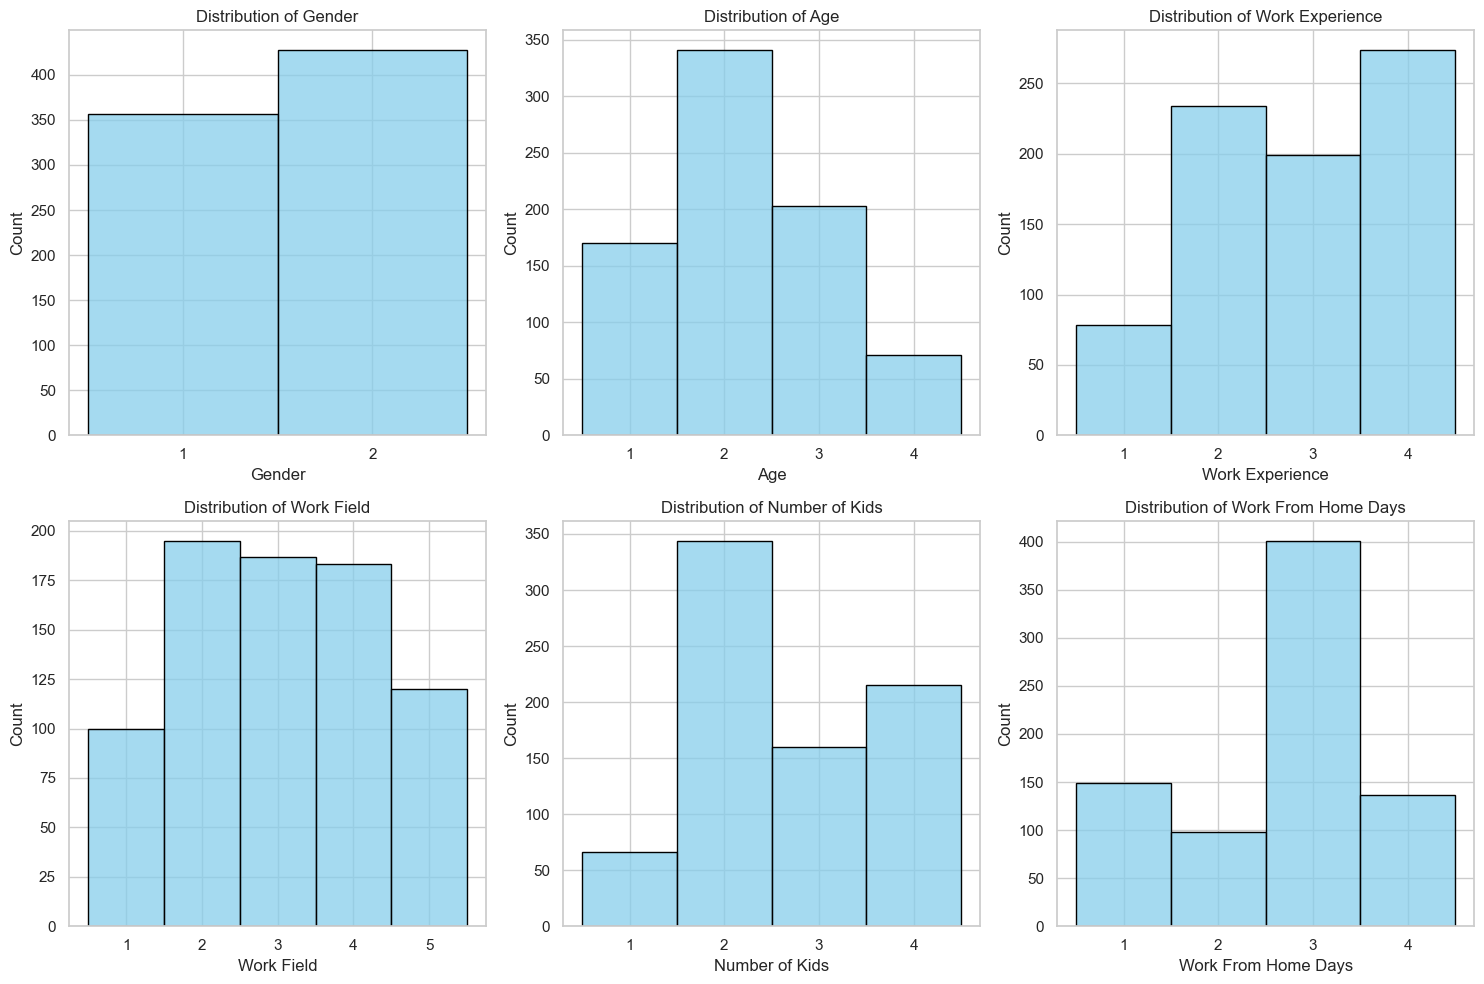

In [269]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Use the original dataset
columns_to_plot = ['Gender', 'Age', 'WorkExper', 'WorkField', 'NoKids', 'WFHDay']

# Mapping for prettier titles
column_titles = {
    'Gender': 'Gender',
    'Age': 'Age',
    'WorkExper': 'Work Experience',
    'WorkField': 'Work Field',
    'NoKids': 'Number of Kids',
    'WFHDay': 'Work From Home Days'
}

# Plotting style
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))

# Subplots
for i, col in enumerate(columns_to_plot):
    plt.subplot(2, 3, i + 1)
    data = df_old[col].astype(int)  # Convert to integer (in case of float)
    sns.histplot(data, discrete=True, color='skyblue', edgecolor='black')
    title = column_titles.get(col, col)
    plt.title(f'Distribution of {title}')
    plt.xlabel(title)
    plt.ylabel('Count')
    plt.xticks(sorted(data.unique()))

plt.tight_layout()
plt.show()


In [273]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("WFH-785.csv")

# Step 1: Define target and features
X = df.drop(columns=['WFHP'])
y = df['WFHP']

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 3: Identify nominal categorical columns
nominal_cols = ['Position', 'WorkField']

# Step 4: One-hot encode nominal variables in training set
X_train_encoded = pd.get_dummies(X_train, columns=nominal_cols, drop_first=False)

# Step 5: One-hot encode test set using **same columns** as training set
X_test_encoded = pd.get_dummies(X_test, columns=nominal_cols, drop_first=False)

# Align test set columns to training set
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Now X_train_encoded and X_test_encoded are ready for oversampling and modeling
print(X_train_encoded.shape)
print(X_test_encoded.shape)


(628, 20)
(157, 20)


In [275]:
print(X_train_encoded.columns.tolist())


['Gender', 'Age', 'Education', 'WorkExper', 'WFHDay', 'WFHMems', 'NoMems', 'NoKids', 'FWC', 'SE', 'WE', 'Position_1', 'Position_2', 'Position_3', 'Position_4', 'WorkField_1', 'WorkField_2', 'WorkField_3', 'WorkField_4', 'WorkField_5']


In [277]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Step 3: Combine encoded training features and target
df_train_encoded = pd.concat([X_train_encoded.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)

# Step 4: Identify underrepresented scores in the training set
minority_scores = [1.0, 2.0, 5.0]
df_minority = df_train_encoded[df_train_encoded['WFHP'].isin(minority_scores)]

# Step 5: Define number of synthetic samples per minority group
n_samples_per_group = {
    1.0: 75,
    2.0: 65,
    5.0: 50,
}

synthetic_samples = []

# Step 6: Generate synthetic samples
for score in minority_scores:
    group = df_minority[df_minority['WFHP'] == score]
    X_group = group.drop(columns=['WFHP']).values  # encoded features
    y_group = group['WFHP'].values

    k = min(5, len(X_group))
    nn = NearestNeighbors(n_neighbors=k).fit(X_group)

    for _ in range(n_samples_per_group[score]):
        idx = np.random.randint(0, len(X_group))
        x_seed = X_group[idx]
        y_seed = y_group[idx]

        neighbors = nn.kneighbors([x_seed], return_distance=False)[0]
        neighbor_idx = np.random.choice(neighbors)
        x_neighbor = X_group[neighbor_idx]
        y_neighbor = y_group[neighbor_idx]

        alpha = np.random.normal(loc=0.5, scale=0.2)
        alpha = np.clip(alpha, 0, 1)

        x_synth = x_seed + alpha * (x_neighbor - x_seed)
        y_synth = y_seed + alpha * (y_neighbor - y_seed)

        y_synth_rounded = np.clip(round(y_synth), 1, 5)
        synthetic_row = list(x_synth) + [y_synth_rounded]
        synthetic_samples.append(synthetic_row)

# Step 7: Create DataFrame using encoded feature columns
columns = list(X_train_encoded.columns) + ['WFHP']
df_synthetic = pd.DataFrame(synthetic_samples, columns=columns)

# Step 8: Merge with encoded training data
df_train_augmented = pd.concat([df_train_encoded, df_synthetic], ignore_index=True)

# Step 9: Remove duplicates
df_train_augmented_no_duplicates = df_train_augmented.drop_duplicates(
    subset=columns, keep=False)

# Step 10: (Optional) Add back original duplicates if needed
df_train_original_duplicates = df_train_encoded[df_train_encoded.duplicated(subset=columns, keep=False)]
df_train_augmented_final = pd.concat(
    [df_train_augmented_no_duplicates, df_train_original_duplicates],
    ignore_index=True)

# Final training sets
X_train_aug = df_train_augmented_final.drop(columns=['WFHP'])
y_train_aug = df_train_augmented_final['WFHP']

# Step 12: Output info
print(f"Original training dataset size: {len(df_train_encoded)}")
print(f"Synthetic samples added: {len(df_synthetic)}")
print(f"Augmented training dataset size: {len(df_train_augmented_final)}")
print(f"Test set size (untouched): {len(X_test_encoded)}")  # use encoded test set


Original training dataset size: 628
Synthetic samples added: 190
Augmented training dataset size: 743
Test set size (untouched): 157


In [279]:
df_test = pd.concat([X_test, y_test], axis=1)
df_augmented = pd.concat([df_train_augmented_final, df_test], ignore_index=True)
print(df_augmented['WFHP'].value_counts().sort_index())

WFHP
1     57
2     96
3    331
4    318
5     98
Name: count, dtype: int64


In [281]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from math import sqrt

# Use your oversampled training data here:
X_train_used = X_train_aug
y_train_used = y_train_aug

# Keep your test data untouched
X_test_used = X_test_encoded
y_test_used = y_test

# Define parameter grid as before
param_grid = {
    'max_depth': [3, 5, 10, 15],
    'min_samples_split': [4, 5, 6, 7],
    'min_samples_leaf': [2, 3, 4]
}

# Initialize model
dt = DecisionTreeRegressor(random_state=42)

# Grid search
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit on oversampled training data
grid_search.fit(X_train_used, y_train_used)
best_dt = grid_search.best_estimator_

# Predict on train and test sets
y_train_pred = best_dt.predict(X_train_used)
y_test_pred = best_dt.predict(X_test_used)

# Evaluation on training data
mae_train = mean_absolute_error(y_train_used, y_train_pred)
mse_train = mean_squared_error(y_train_used, y_train_pred)
rmse_train = sqrt(mse_train)

# Evaluation on test data
mae_test = mean_absolute_error(y_test_used, y_test_pred)
mse_test = mean_squared_error(y_test_used, y_test_pred)
rmse_test = sqrt(mse_test)

# 5-fold CV scores on oversampled training data
mae_scores = cross_val_score(best_dt, X_train_used, y_train_used, cv=5, scoring=make_scorer(mean_absolute_error))
mse_scores = cross_val_score(best_dt, X_train_used, y_train_used, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-mse_scores)

# Output results
print("Best Hyperparameters:", grid_search.best_params_)

print("\nTraining Set Evaluation:")
print(f"MAE: {mae_train:.4f}")
print(f"MSE: {mse_train:.4f}")
print(f"RMSE: {rmse_train:.4f}")

print("\nTest Set Evaluation:")
print(f"MAE: {mae_test:.4f}")
print(f"MSE: {mse_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")

print("\n5-Fold Cross-Validation on Training Set:")
print(f"Average MAE: {mae_scores.mean():.4f}")
print(f"Average MSE: {-mse_scores.mean():.4f}")
print(f"Average RMSE: {rmse_scores.mean():.4f}")


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 4}

Training Set Evaluation:
MAE: 0.4171
MSE: 0.2978
RMSE: 0.5457

Test Set Evaluation:
MAE: 0.5349
MSE: 0.4196
RMSE: 0.6478

5-Fold Cross-Validation on Training Set:
Average MAE: 0.5752
Average MSE: 0.5631
Average RMSE: 0.7440


In [283]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from math import sqrt

# Use your oversampled training data here:
X_train_used = X_train_aug
y_train_used = y_train_aug

# Keep your test data untouched
X_test_used = X_test_encoded
y_test_used = y_test

# Parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_features': ['sqrt'],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [5, 8, 10],
    'min_samples_leaf': [2, 3, 4]
}

# Initialize Random Forest
rf = RandomForestRegressor(random_state=42)

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit on oversampled training data
grid_search.fit(X_train_used, y_train_used)
best_rf = grid_search.best_estimator_

# Predict on oversampled training data
y_train_pred = best_rf.predict(X_train_used)
# Predict on original test data
y_test_pred = best_rf.predict(X_test_used)

# Calculate training metrics
mae_train = mean_absolute_error(y_train_used, y_train_pred)
mse_train = mean_squared_error(y_train_used, y_train_pred)
rmse_train = sqrt(mse_train)

# Calculate test metrics
mae_test = mean_absolute_error(y_test_used, y_test_pred)
mse_test = mean_squared_error(y_test_used, y_test_pred)
rmse_test = sqrt(mse_test)

# Cross-validation on oversampled training data
neg_mse_scores = cross_val_score(best_rf, X_train_used, y_train_used, scoring='neg_mean_squared_error', cv=5)
cv_mse = -np.mean(neg_mse_scores)
cv_rmse = np.mean(np.sqrt(-neg_mse_scores))  # average RMSE

neg_mae_scores = cross_val_score(best_rf, X_train_used, y_train_used, scoring='neg_mean_absolute_error', cv=5)
cv_mae = -np.mean(neg_mae_scores)

# Output results
print("Best Hyperparameters:", grid_search.best_params_)

print(f"\nTraining Set Evaluation:")
print(f"MAE: {mae_train:.4f}")
print(f"MSE: {mse_train:.4f}")
print(f"RMSE: {rmse_train:.4f}")

print(f"\nTest Set Evaluation:")
print(f"MAE: {mae_test:.4f}")
print(f"MSE: {mse_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")

print(f"\nCross-Validation on Training Set (5-fold):")
print(f"Average MAE: {cv_mae:.4f}")
print(f"Average MSE: {cv_mse:.4f}")
print(f"Average RMSE: {cv_rmse:.4f}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Hyperparameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

Training Set Evaluation:
MAE: 0.3108
MSE: 0.1492
RMSE: 0.3863

Test Set Evaluation:
MAE: 0.4763
MSE: 0.3534
RMSE: 0.5944

Cross-Validation on Training Set (5-fold):
Average MAE: 0.5413
Average MSE: 0.4310
Average RMSE: 0.6438


In [285]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

# Use your oversampled training data here:
X_train_used = X_train_aug
y_train_used = y_train_aug

# Keep your test data untouched
X_test_used = X_test_encoded
y_test_used = y_test

# Hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05],
    'min_samples_split': [3, 4, 5],
    'min_samples_leaf': [3, 4, 5]
}

# Initialize model
gbr = GradientBoostingRegressor(random_state=42)

# Grid search with 5-fold CV
grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit model on oversampled training data
grid_search.fit(X_train_used, y_train_used)
best_gbr = grid_search.best_estimator_

# Predict on training and test data
y_train_pred = best_gbr.predict(X_train_used)
y_test_pred = best_gbr.predict(X_test_used)

# Calculate training metrics
mae_train = mean_absolute_error(y_train_used, y_train_pred)
mse_train = mean_squared_error(y_train_used, y_train_pred)
rmse_train = sqrt(mse_train)

# Calculate test metrics
mae_test = mean_absolute_error(y_test_used, y_test_pred)
mse_test = mean_squared_error(y_test_used, y_test_pred)
rmse_test = sqrt(mse_test)

# Cross-validation scores on oversampled training data
mae_scores = cross_val_score(best_gbr, X_train_used, y_train_used, scoring='neg_mean_absolute_error', cv=5)
mse_scores = cross_val_score(best_gbr, X_train_used, y_train_used, scoring='neg_mean_squared_error', cv=5)

cv_mae = -np.mean(mae_scores)
cv_mse = -np.mean(mse_scores)
cv_rmse = np.mean(np.sqrt(-mse_scores))

# Output results
print("Best Hyperparameters:", grid_search.best_params_)

print(f"\nTraining Set Evaluation:")
print(f"MAE: {mae_train:.4f}")
print(f"MSE: {mse_train:.4f}")
print(f"RMSE: {rmse_train:.4f}")

print(f"\nTest Set Evaluation:")
print(f"MAE: {mae_test:.4f}")
print(f"MSE: {mse_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")

print(f"\nCross-Validation on Training Set (5-fold):")
print(f"Average MAE: {cv_mae:.4f}")
print(f"Average MSE: {cv_mse:.4f}")
print(f"Average RMSE: {cv_rmse:.4f}")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 150}

Training Set Evaluation:
MAE: 0.3203
MSE: 0.1716
RMSE: 0.4142

Test Set Evaluation:
MAE: 0.4935
MSE: 0.3862
RMSE: 0.6214

Cross-Validation on Training Set (5-fold):
Average MAE: 0.5055
Average MSE: 0.3944
Average RMSE: 0.6260


In [287]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from math import sqrt

# Use your oversampled training data here (make sure X_train_aug is a DataFrame or ndarray)
X_train_used = X_train_aug
y_train_used = y_train_aug

# Keep your test data untouched (already scaled)
X_test_used = X_test_encoded
y_test_used = y_test

# Scale the training data (fit scaler only on training data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_used)

# Scale the test data with the same scaler
X_test_scaled = scaler.transform(X_test_used)

# Hyperparameter grid for K-NN
param_grid = {
    'n_neighbors': [7, 9, 11, 13, 15],
    'weights': ['uniform'],   # you can try 'distance' too
    'algorithm': ['auto'],
    'p': [2]  # Euclidean distance
}

# Initialize model
knn = KNeighborsRegressor()

# GridSearchCV with 5-fold CV on scaled training data
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearch on scaled training data
grid_search.fit(X_train_scaled, y_train_used)
best_knn = grid_search.best_estimator_

# Predict on training and test data
y_train_pred = best_knn.predict(X_train_scaled)
y_test_pred = best_knn.predict(X_test_scaled)

# Calculate training metrics
mae_train = mean_absolute_error(y_train_used, y_train_pred)
mse_train = mean_squared_error(y_train_used, y_train_pred)
rmse_train = sqrt(mse_train)

# Calculate test metrics
mae_test = mean_absolute_error(y_test_used, y_test_pred)
mse_test = mean_squared_error(y_test_used, y_test_pred)
rmse_test = sqrt(mse_test)

# Cross-validation scores on scaled training data
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
cv_mse_scores = cross_val_score(best_knn, X_train_scaled, y_train_used, scoring='neg_mean_squared_error', cv=5)
cv_mae_scores = cross_val_score(best_knn, X_train_scaled, y_train_used, scoring=mae_scorer, cv=5)

cv_mse = -np.mean(cv_mse_scores)
cv_rmse = np.mean(np.sqrt(-cv_mse_scores))
cv_mae = -np.mean(cv_mae_scores)

# Output results
print("Best Hyperparameters:", grid_search.best_params_)

print(f"\nTraining Set Evaluation:")
print(f"MAE: {mae_train:.4f}")
print(f"MSE: {mse_train:.4f}")
print(f"RMSE: {rmse_train:.4f}")

print(f"\nTest Set Evaluation:")
print(f"MAE: {mae_test:.4f}")
print(f"MSE: {mse_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")

print(f"\nCross-Validation on Training Set (5-fold):")
print(f"Average MAE: {cv_mae:.4f}")
print(f"Average MSE: {cv_mse:.4f}")
print(f"Average RMSE: {cv_rmse:.4f}")


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}

Training Set Evaluation:
MAE: 0.4449
MSE: 0.3260
RMSE: 0.5709

Test Set Evaluation:
MAE: 0.5350
MSE: 0.4451
RMSE: 0.6671

Cross-Validation on Training Set (5-fold):
Average MAE: 0.6498
Average MSE: 0.6236
Average RMSE: 0.7805


C:\Users\Megan\AppData\Local\Temp\ipykernel_21692\783520621.py:84: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


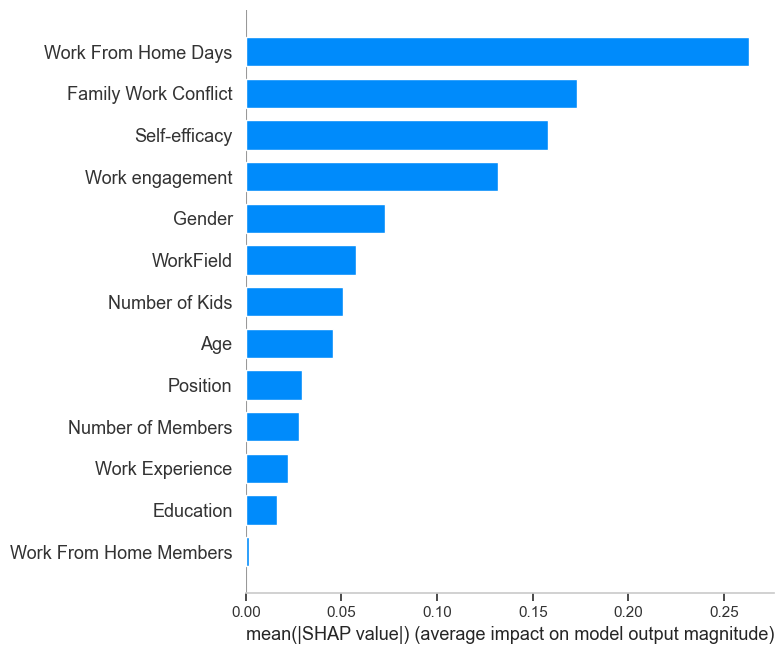

C:\Users\Megan\AppData\Local\Temp\ipykernel_21692\783520621.py:96: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


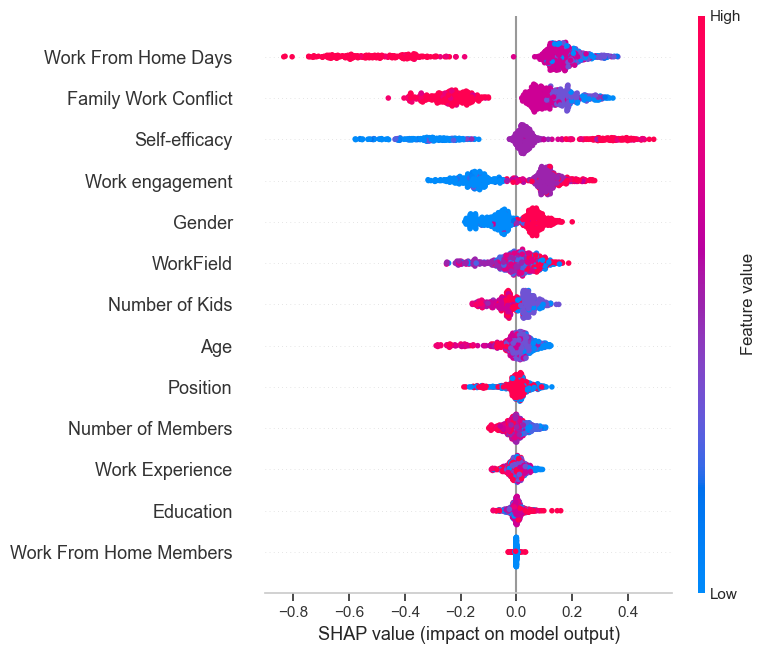

In [289]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap
import matplotlib.pyplot as plt

# Assume df is your original data and you already have X_train_aug, y_train_aug after oversampling

# Define your one-hot encoded groups
workfield_cols = ['WorkField_1', 'WorkField_2', 'WorkField_3', 'WorkField_4', 'WorkField_5']
position_cols = ['Position_1', 'Position_2', 'Position_3', 'Position_4']

# Train your Random Forest model on the oversampled data
rf_best = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=5,
    random_state=42
)
rf_best.fit(X_train_aug, y_train_aug)

# Calculate SHAP values for oversampled training data
explainer = shap.TreeExplainer(rf_best)
shap_values = explainer.shap_values(X_train_aug)

# Get columns NOT in groups
other_cols = [col for col in X_train_aug.columns if col not in workfield_cols + position_cols]

# Get indices for these columns
workfield_idx = [X_train_aug.columns.get_loc(col) for col in workfield_cols]
position_idx = [X_train_aug.columns.get_loc(col) for col in position_cols]
other_idx = [X_train_aug.columns.get_loc(col) for col in other_cols]

# Combine SHAP values by summing (keep signs!)
combined_workfield_shap = shap_values[:, workfield_idx].sum(axis=1)
combined_position_shap = shap_values[:, position_idx].sum(axis=1)
other_shap_values = shap_values[:, other_idx]

# Combine all SHAP values: other features + combined WorkField + combined Position
combined_shap_values = np.hstack([
    other_shap_values,
    combined_workfield_shap.reshape(-1, 1),
    combined_position_shap.reshape(-1, 1)
])

# Combined feature names
combined_feature_names = other_cols + ['WorkField', 'Position']

# Prepare combined feature matrix for plotting
combined_X = pd.DataFrame(0, index=np.arange(X_train_aug.shape[0]), columns=combined_feature_names)
combined_X[other_cols] = X_train_aug[other_cols].reset_index(drop=True)

# For grouped categorical features, create numeric indices from one-hot max (for coloring in beeswarm)
combined_X['WorkField'] = X_train_aug[workfield_cols].idxmax(axis=1).apply(lambda x: workfield_cols.index(x)).values
combined_X['Position'] = X_train_aug[position_cols].idxmax(axis=1).apply(lambda x: position_cols.index(x)).values

# Optional: Rename columns in combined_X for plotting
rename_dict = {
    'WFHDay': 'Work From Home Days',
    'FWC': 'Family Work Conflict',
    'SE': 'Self-efficacy',
    'WE': 'Work engagement',
    'NoKids': 'Number of Kids',
    'NoMems': 'Number of Members',
    'WFHMems': 'Work From Home Members',
    'WorkExper': 'Work Experience',
    'WorkField': 'WorkField',
    'Position': 'Position'
}
combined_X.rename(columns=rename_dict, inplace=True)

# Apply rename to feature names list for plotting
combined_feature_names_renamed = [rename_dict.get(col, col) for col in combined_feature_names]

# Make sure shapes match exactly (trim if needed)
min_rows = min(combined_shap_values.shape[0], combined_X.shape[0])
combined_shap_values = combined_shap_values[:min_rows]
combined_X = combined_X.iloc[:min_rows]

# Plot SHAP summary bar plot
shap.summary_plot(
    combined_shap_values,
    combined_X.values,
    feature_names=combined_feature_names_renamed,
    plot_type="bar",
    show=False
)
plt.grid(False)
plt.tight_layout()
plt.show()

# Plot SHAP summary dot (beeswarm) plot
shap.summary_plot(
    combined_shap_values,
    combined_X.values,
    feature_names=combined_feature_names_renamed,
    plot_type="dot",
    show=False
)
plt.grid(False)
plt.tight_layout()
plt.show()


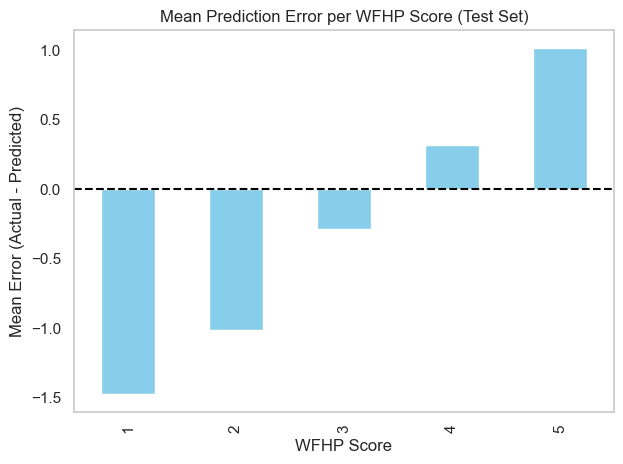

In [291]:
import pandas as pd
import matplotlib.pyplot as plt

# Predict on the original test data
y_pred_test = best_rf.predict(X_test_used)

# Calculate errors on test set
errors_test = y_test - y_pred_test

# Combine into a DataFrame for test set error analysis
error_test_df = pd.DataFrame({
    'Actual_WFHP': y_test,
    'Predicted_WFHP': y_pred_test,
    'Error': errors_test
})

# Group by actual WFHP score in the test set
grouped_error_test = error_test_df.groupby('Actual_WFHP')['Error'].agg(['mean', 'count'])

# Plot mean error only (no error bars)
grouped_error_test['mean'].plot(
    kind='bar',
    color='skyblue',
    title='Mean Prediction Error per WFHP Score (Test Set)'
)
plt.axhline(0, color='black', linestyle='--')  # baseline at 0
plt.ylabel('Mean Error (Actual - Predicted)')
plt.xlabel('WFHP Score')
plt.grid(False)  # Removes grid lines
plt.tight_layout()
plt.show()


In [258]:
# Print numerical grouped errors rounded to 3 decimals
print(grouped_error_test.round(3))


              mean  count
Actual_WFHP              
1           -1.478      1
2           -1.011     11
3           -0.286     66
4            0.318     64
5            1.017     15


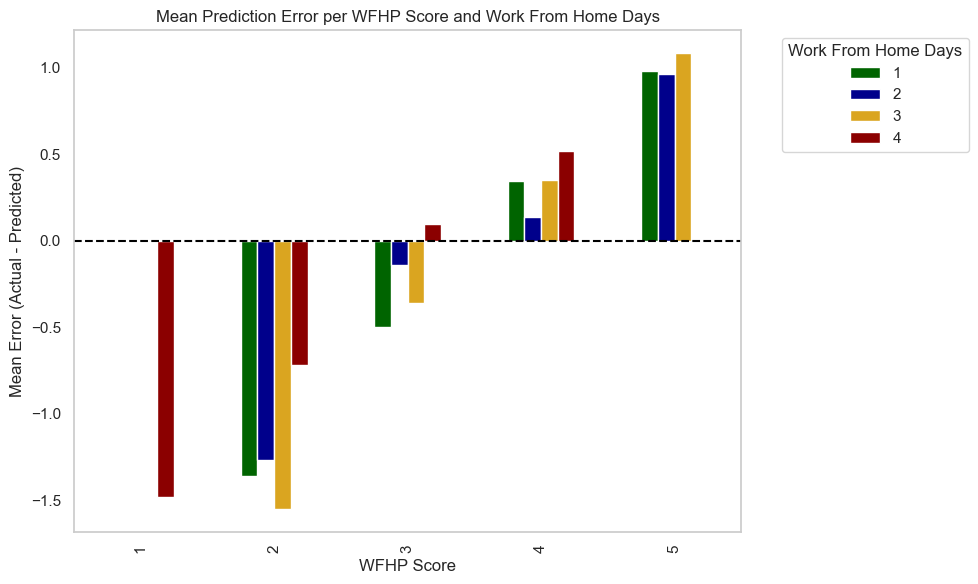

In [260]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure feature consistency with the trained model
X_test_features_only = X_test_used[rf_best.feature_names_in_]

# Get predictions and errors
y_pred = rf_best.predict(X_test_features_only)
errors = y_test - y_pred

# Combine into a single DataFrame (include WFHDay for grouping)
error_df = X_test_used.copy()
error_df['WFHDay'] = error_df['WFHDay'].astype(int)  # Convert WFHDay to integer
error_df['Actual_WFHP'] = y_test
error_df['Predicted_WFHP'] = y_pred
error_df['Error'] = errors

# Group by Actual WFHP and Remote Work Frequency
grouped_error = error_df.groupby(['Actual_WFHP', 'WFHDay'])['Error'].mean().unstack()

# Define darker custom colors
custom_colors = {
    1: 'darkgreen',
    2: 'darkblue',
    3: 'goldenrod',
    4: 'darkred'
}
color_list = [custom_colors[day] for day in grouped_error.columns]

# Plot
grouped_error.plot(
    kind='bar',
    figsize=(10, 6),
    color=color_list
)
plt.axhline(0, color='black', linestyle='--')  # baseline at 0
plt.title('Mean Prediction Error per WFHP Score and Work From Home Days')
plt.ylabel('Mean Error (Actual - Predicted)')
plt.xlabel('WFHP Score')
plt.legend(title='Work From Home Days', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(False)  # ✅ Removes grid lines
plt.tight_layout()
plt.show()


In [262]:
# Create the numerical table of mean errors
grouped_error_table = error_df.groupby(['Actual_WFHP', 'WFHDay'])['Error'].mean().unstack()

# Round for easier readability
grouped_error_table = grouped_error_table.round(3)

# Display the table
print(grouped_error_table)


WFHDay           1      2      3      4
Actual_WFHP                            
1              NaN    NaN    NaN -1.478
2           -1.360 -1.265 -1.549 -0.721
3           -0.500 -0.138 -0.359  0.096
4            0.344  0.137  0.350  0.515
5            0.980  0.963  1.082    NaN
